### Conculsion
- Multiple tests with K 3, 5, 7, and 9
- The performance didn't change after 7, as the accuracy was 78%, 81%, 83%, and 83%. Therefore, k=7 was selected.
- The performance didn't change without the utterances classes features
- Forest plot for odds ratio

## Install required packages

This script was based on the article below:
https://medium.com/@knoldus/how-to-find-correlation-value-of-categorical-variables-23de7e7a9e26

I should add a reference for this

"It calculates the correlation/strength-of-association of features in the data-set with both categorical and continuous features using: Pearson’s R for continuous-continuous cases, Correlation Ratio for categorical-continuous cases, Cramer’s V or Theil’s U for categorical-categorical cases."

In [1]:
# !pip install psycopg2-binary
!pip --version

!pip install -r requirements.txt

pip 23.0.1 from /opt/conda/lib/python3.10/site-packages/pip (python 3.10)


## Do general imports

In [2]:
from classifiers.testing import cycle_test,TestType,TestInputs,DatasetFeatures
from pandas.api.types import CategoricalDtype
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

score_category = CategoricalDtype(categories=[0, 1, 2], ordered=True)

In [3]:
import math as m
m.exp(-0.6395)

0.5275561361776098

In [4]:
# Define function to output plot of the model coefficients
# https://gist.github.com/JessicaFB/30e9fbe390fb2207e9f86b25d1e686c2
def coefplot(results):
    '''
    Takes in results of OLS model and returns a plot of 
    the coefficients with 95% confidence intervals.
    
    Removes intercept, so if uncentered will return error.
    '''
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)
    coef_df['coef'] = [m.exp(v) for v in coef_df['coef'].values]
    coef_df['[0.025'] = [m.exp(v) for v in coef_df['[0.025'].values]

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    
    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    coef_df = coef_df.drop(['0/1','1/2'])

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])

    ### Plot Coefficients ###

    # x-labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables
    # print(coef_df)
    # Set sns plot style back to 'poster'
    # This will make bars wide on plot
    sns.set_context("poster")

    # Define figure, axes, and plot
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot()
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', kind='barh',
                 ax=ax, color='none', 
                 ecolor='steelblue',capsize=0,
                 xerr='errors', legend=False)
    
    # Set title & labels
    # plt.title('Coefficients of Features w/ 95% Confidence Intervals',fontsize=30)
    ax.set_ylabel('',fontsize=22)
    ax.set_xlabel('Odds Ratio',fontsize=22)
    
    # Coefficients
    ax.scatter(y=pd.np.arange(coef_df.shape[0]), 
               marker='o', s=80, 
               x=coef_df['coef'], color='steelblue')
    
    # Line to define zero on the y-axis
    ax.axvline(x=1, linestyle='--', color='red', linewidth=1)
    
    return plt.show()

### Options

In [5]:
# option 1: all aggregated features
# option 2: Aggregated WF time and detailed features for utterances
# option 3: Aggregated utterances and detailed WF time
# option 4: Detailed WF time and Detailed utterances features


assignee_utterances = [
    'utr_assignee_open_close',
           'utr_assignee_inform', 'utr_assignee_user_mention',
           'utr_assignee_resolution', 'utr_assignee_technical',
           'utr_assignee_investigation', 'utr_assignee_assignment_update',
           'utr_assignee_reminder', 'utr_assignee_status_update',
           'utr_assignee_support_session']

reporter_utterances =[
            'utr_reporter_user_mention',
           'utr_reporter_open_close', 'utr_reporter_support_session',
           'utr_reporter_request', 'utr_reporter_attach_info',
           'utr_reporter_resolution', 'utr_reporter_inform',
           'utr_reporter_technical']

others_utterances=[
    'utr_others_open_close',
           'utr_others_user_mention', 'utr_others_investigation',
           'utr_others_reminder', 'utr_others_assignment_update',
           'utr_others_technical', 'utr_others_request',
           'utr_others_resolution_update', 'utr_others_update_request',
           'utr_others_resolution']

wf_features =[
        'wf_resolved',
        'wf_open', 
        'wf_in_progress',
        'wf_reopened',
        'wf_validation',
        'wf_resolved_under_monitoring',
        'wf_closed',  
        'wf_waiting', 
        'wf_pending_deployment']

wfe_features =[
        'wfe_resolved',
        'wfe_open', 
        'wfe_in_progress',
        'wfe_reopened',
        'wfe_validation',
        'wfe_resolved_under_monitoring',
        'wfe_closed',  
        'wfe_waiting', 
        'wfe_pending_deployment']



aggregated_utterances = ['assignee_utterances_count','reporter_utterances_count','others_utterances_count']
option1 = []
option1.extend(aggregated_utterances)
option1.extend(['processing_steps'])
option1.extend(['wf_total_time'])

option2 = []
option2.extend(assignee_utterances)
option2.extend(reporter_utterances)
option2.extend(others_utterances)
option2.extend(['processing_steps'])
option2.extend(['wf_total_time'])

option3 = []
option3.extend(aggregated_utterances)
option3.extend(['processing_steps'])
option3.extend(wf_features)

option4 = []
option4.extend(assignee_utterances)
option4.extend(reporter_utterances)
option4.extend(others_utterances)
option4.extend(wf_features)
option4.extend(['processing_steps'])

# option5 = ['utr_assignee_inform','utr_assignee_resolution','utr_assignee_investigation','utr_assignee_assignment_update','utr_assignee_status_update',
#            'utr_reporter_user_mention','utr_reporter_attach_info','utr_reporter_inform',
#            'utr_others_investigation','utr_others_assignment_update','utr_others_technical','utr_others_resolution_update','utr_others_update_request',
#            'processing_steps','wf_total_time']
# option5 = ['utr_assignee_assignment_update',
#  'utr_others_update_request',
#  'utr_assignee_open_close',
#  'wf_total_time',
#  'utr_others_assignment_update',
#  'utr_assignee_resolution',
#  'utr_assignee_inform',
#  'utr_reporter_resolution',
#  'utr_others_resolution_update',
#  'utr_others_open_close',
#  'utr_reporter_attach_info',
#  'utr_reporter_inform',
#           'processing_steps']
option5 = ['utr_assignee_assignment_update',
 'utr_others_update_request',
 'utr_assignee_open_close',
 'wf_total_time',
 'utr_others_assignment_update',
 'utr_assignee_resolution',
 'utr_assignee_inform',
 'utr_reporter_resolution',
 'utr_others_resolution_update',
 'utr_others_open_close',
 'utr_reporter_attach_info',
 'utr_reporter_inform']
option5.sort()

option6 = ['utr_assignee_assignment_update',
 'wf_total_time',
 'utr_others_user_mention',
 'utr_assignee_open_close',
 'utr_others_assignment_update',
 'utr_assignee_status_update',
 'utr_reporter_attach_info',
 'utr_reporter_resolution',
 'utr_assignee_user_mention',
 'utr_others_resolution_update',
 'utr_others_update_request',
 'utr_reporter_technical',
 'utr_reporter_user_mention']
option6.sort()


### Ordinal Logistic Regression

In [6]:
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import operator

summary = [None]
options = [
    # ('Aggregated features',option1),
    # ('Detailed utterances, aggregated workflow time',option2),
    # ('Aggregated utterances, detailed workflow time',option3),
    # ('Detailed utterances, detailed workflow time',option4),
    ('Best features #',option5,DatasetFeatures.WITH_TEXT_TONE_AS_COUNTS),
    ('Best features %',option6,DatasetFeatures.WITH_TEXT_TONE_AS_PERCENTAGES)]

def fit_and_test(inputs: TestInputs):
    # print(f'{inputs.x_train.columns}')
    # print(f'selected {len(features)} features {features}')
    
    inputs.y_train['Q1'] = inputs.y_train['Q1'].astype(score_category)
    inputs.y_test['Q1'] = inputs.y_test['Q1'].astype(score_category)
    
    mod_prob = OrderedModel(inputs.y_train['Q1'],
                        inputs.x_train[features],
                        distr='logit')
    # hasconst=False
    res_log = mod_prob.fit(method='bfgs',maxiter=1000)
    summary[0] = (res_log.summary())
    
    predicted_prop = res_log.model.predict(res_log.params, exog=inputs.x_test[features])   
    
    coefplot(res_log)
    return predicted_prop.argmax(1)   


### Run

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
Best features #
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
start test Ordinal Logistic Regression to test Three Levels
Total records in dataset 747
total records in learning dataset 747
total number of records in learning 603
total records in learning dataset 747
total number of records in learning 603
Optimization terminated successfully.
         Current function value: 0.672566
         Iterations: 40
         Function evaluations: 41
         Gradient evaluations: 41


/opt/conda/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/tmp/ipykernel_4765/1378586847.py:69: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  ax.scatter(y=pd.np.arange(coef_df.shape[0]),


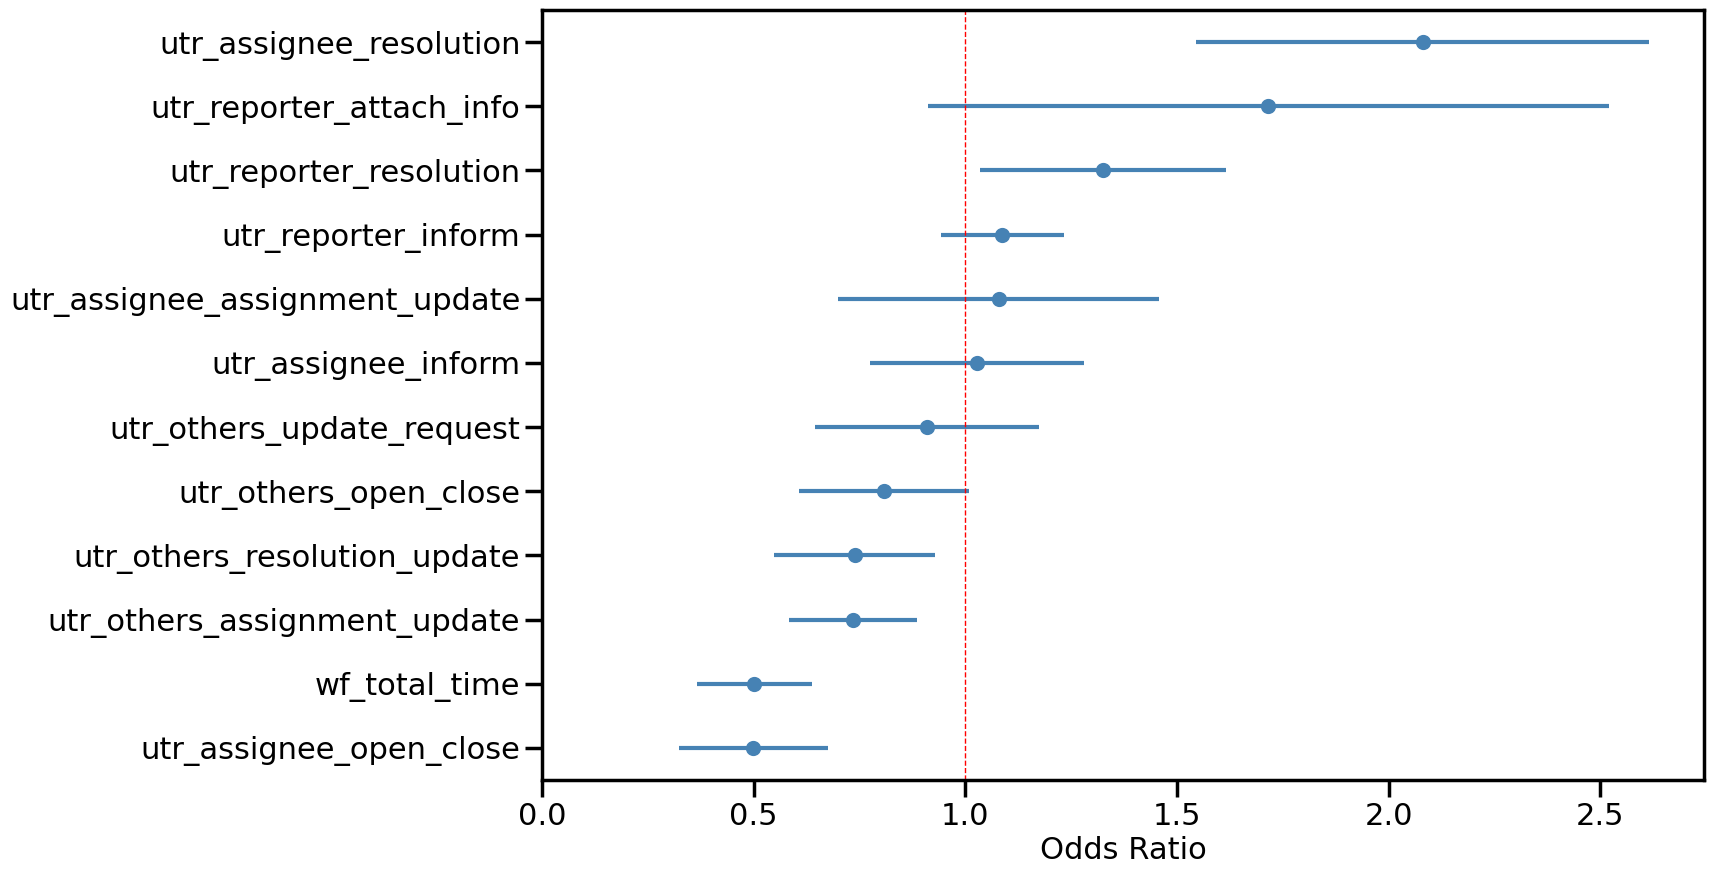

Three Levels - With DA features (counts)
              precision    recall  f1-score   support

           0       0.52      0.39      0.45        28
           1       0.29      0.12      0.17        42
           2       0.75      0.96      0.84       111

    accuracy                           0.68       181
   macro avg       0.52      0.49      0.49       181
weighted avg       0.61      0.68      0.63       181

                             OrderedModel Results                             
Dep. Variable:                     Q1   Log-Likelihood:                -283.82
Model:                   OrderedModel   AIC:                             595.6
Method:            Maximum Likelihood   BIC:                             652.3
Date:                Tue, 03 Dec 2024                                         
Time:                        20:01:59                                         
No. Observations:                 422                                         
Df Residuals:            

/opt/conda/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/tmp/ipykernel_4765/1378586847.py:69: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  ax.scatter(y=pd.np.arange(coef_df.shape[0]),


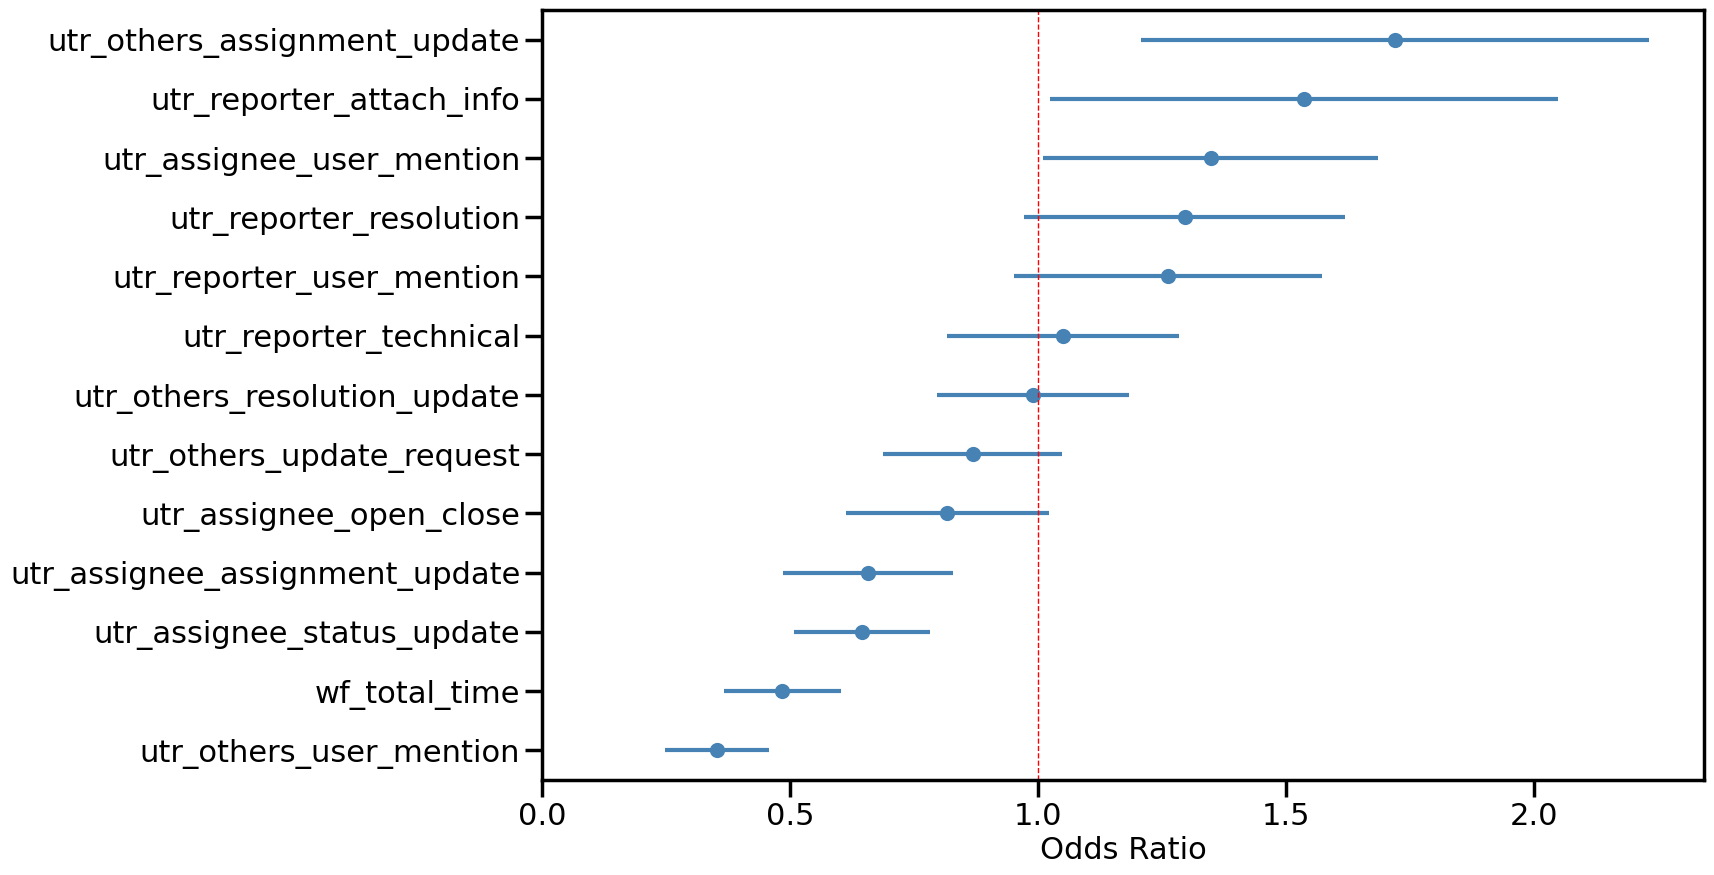

Three Levels - With DA features (%)
              precision    recall  f1-score   support

           0       0.57      0.43      0.49        28
           1       0.42      0.24      0.30        42
           2       0.75      0.92      0.83       111

    accuracy                           0.69       181
   macro avg       0.58      0.53      0.54       181
weighted avg       0.65      0.69      0.65       181

                             OrderedModel Results                             
Dep. Variable:                     Q1   Log-Likelihood:                -276.27
Model:                   OrderedModel   AIC:                             582.5
Method:            Maximum Likelihood   BIC:                             643.2
Date:                Tue, 03 Dec 2024                                         
Time:                        20:02:00                                         
No. Observations:                 422                                         
Df Residuals:                 

In [7]:

def pre_process(x,y):
    # min_max_f = [c for c in x.columns if c.startswith('wf_')]
    # min_max_f = features
    num_x = x.select_dtypes(include='number')
    x[num_x.columns] = StandardScaler().fit_transform(num_x[num_x.columns])
    # x.loc[:,min_max_f] = StandardScaler().fit_transform(x[min_max_f])
    return x,y

for option in options:
    print(f'{"$"*150}')
    print(f'{option[0]}')
    print(f'{"$"*150}')
    features = option[1]
    cycle_test('Ordinal Logistic Regression',
            fit_and_test,
            test_type=TestType.THREE_LEVELS,
            dataset_types=option[2],
            pre_processor=pre_process)
    print(summary[0])
    for i in range(1,len(summary[0].tables[1])-2):
        if float(summary[0].tables[1][i][4].data) <= 0.05:
            print(f'\'{summary[0].tables[1][i][0].data}\',',end='')
    print('')
    